## Comparing fitted model to TNG50, TNG100, and TNG300

In [1]:
#imports from FitComparison_3panelPlot
import os
import h5py as h5
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import astropy.units as u
from astropy import constants as const

from scipy import interpolate
from scipy.optimize import minimize
from scipy.optimize import curve_fit

#from astropy.cosmology import WMAP9, z_at_value
from astropy.cosmology import Planck15  as cosmo# Planck 2018
from astropy.cosmology import z_at_value
from astropy.table import Table

from matplotlib import rc
import matplotlib
from matplotlib import ticker, cm
import matplotlib.gridspec as gridspec
from matplotlib import cm
from matplotlib.colors import ListedColormap

############################
# Custom scripts
import get_ZdepSFRD as Z_SFRD
import paths
import init_values as In

In [2]:
data_dir    =  str(paths.data) +'/'
save_loc = str(paths.figures) + '/'
COMPASfilename = 'COMPAS_Output_wWeights.h5'

TNG50filename = 'SFRMetallicityFromGasTNG50-1.hdf5'
rate_file_name_TNG50 = 'Rate_info_TNG50_1.h5'
fit_param_filename_TNG50 = 'test_best_fit_parameters_TNG50.txt'

TNG100filename = 'SFRMetallicityFromGasTNG100-1.hdf5'
rate_file_name_TNG100 = 'Rate_info_TNG100.h5'
fit_param_filename_TNG100 = 'test_best_fit_parameters_TNG100.txt'

TNG300filename = 'SFRMetallicityFromGasTNG300-1.hdf5'
rate_file_name_TNG300 = 'Rate_info_TNG300.h5'
fit_param_filename_TNG300 = 'test_best_fit_parameters_TNG300.txt'

TNG100filename_2 = 'SFRMetallicityFromGasTNG100-2.hdf5'
rate_file_name_TNG100_2 = 'Rate_info_TNG100-2.h5'
fit_param_filename_TNG100_2 = 'test_best_fit_parameters_TNG100-2.txt'

Rboxval50 = 35
Rboxval100 = 75
Rboxval300 = 205 

In [3]:
#define chirp mass function
def Mchirp(m1, m2):
    chirp_mass = np.divide(np.power(np.multiply(m1, m2), 3./5.), np.power(np.add(m1, m2), 1./5.))
    return chirp_mass   

In [5]:
#values
In.init()
Zsun = 0.014 # Solar metallicity
mu0_best50, muz_best50, omega0_best50, omegaz_best50, alpha0_best50, sf_a_best50, sf_b_best50, sf_c_best50, sf_d_best50 = np.loadtxt(str(paths.data)+'/'+fit_param_filename_TNG50,unpack=True, delimiter=',')
mu0_best100, muz_best100, omega0_best100, omegaz_best100, alpha0_best100, sf_a_best100, sf_b_best100, sf_c_best100, sf_d_best100 = np.loadtxt(str(paths.data)+'/'+fit_param_filename_TNG100,unpack=True, delimiter=',')
mu0_best300, muz_best300, omega0_best300, omegaz_best300, alpha0_best300, sf_a_best300, sf_b_best300, sf_c_best300, sf_d_best300 = np.loadtxt(str(paths.data)+'/'+fit_param_filename_TNG300,unpack=True, delimiter=',')
mu0_best100_2, muz_best100_2, omega0_best100_2, omegaz_best100_2, alpha0_best100_2, sf_a_best100_2, sf_b_best100_2, sf_c_best100_2, sf_d_best100_2 = np.loadtxt(str(paths.data)+'/'+fit_param_filename_TNG100_2,unpack=True, delimiter=',')
obs_SFRD = []
min_logZ  = -12.0
max_logZ  = 0.0
step_logZ = 0.01
add_TNG = False, 
plot_dPdZcontours = True
neijssel_fit = True
FITkleur="crest"
dPdZ_text = ''
SFR_text = ''
tmin = 0.0
tmax = 13.7

In [7]:
mu0_best = [mu0_best50, mu0_best100, mu0_best300, mu0_best100_2]
muz_best = [muz_best50, muz_best100, muz_best300, muz_best100_2]
omega0_best = [omega0_best50, omega0_best100, omega0_best300, omega0_best100_2]
omega0_best = [omegaz_best50, omegaz_best100, omegaz_best300, omegaz_best100_2]
alpha0_best = [alpha0_best50, alpha0_best100, alpha0_best300, alpha0_best100_2]
sf_a_best = [sf_a_best50, sf_a_best100, sf_a_best300, sf_a_best100_2]
sf_b_best = [sf_b_best50, sf_b_best100, sf_b_best300, sf_b_best100_2]
sf_c_best = [sf_c_best50, sf_c_best100, sf_c_best300, sf_c_best100_2]
sf_d_best = [sf_d_best50, sf_d_best100, sf_d_best300, sf_d_best100_2]

## Comparing SFRD(z)

In [8]:
def powerlaw_fit_Chruslinska21(z_bounds= [0,1.0,1.8,4.0,7.0,8.8, 10.0], 
                                   kappa_list = [2.3822, 2.2105, -1.2278,-2.4769, -12.5280, 0],
                                   A_list = [0.0248, 0.028, 0.964, 7.2, 8.6*10**9, 0.00328]):
        """
        Powerlaw approximation from Chruslinska +2021 (Fig. 11 and tables 3 and B2)
        Default values are upper edge of Cosmic SFH – SB: B18/C17 == Thick brown line in fig. 11
        """
        redshifts, SFRD = [], []
        for i in range(len(z_bounds) -1):
            z    = np.linspace(z_bounds[i], z_bounds[i+1], num = 20)
            z    = (z[:-1] + z[1:])/2.
            redshifts.append(z)
            
            vals = A_list[i] * (1 + z)**kappa_list[i]
            SFRD.append(A_list[i] * (1 + z)**kappa_list[i])
            
        redshifts = np.array(redshifts).flatten()
        SFRD      = np.array(SFRD).flatten()
        
        return redshifts, SFRD # Msun /yr /Mpc^3

In [40]:
def plot_SFR(sf_a = 0.017, sf_b = 1.481, sf_c = 4.452,  sf_d = 5.913, show_legend = True,
                 redshift_list  = np.linspace(0,15, num=100), x_redshift = True, show_powerlaw_fit = False,
                 tmin=0.0, tmax = 13.7, readTNG=False):
        ########################################################
        # Start plotting
        fig, ax = plt.subplots(figsize=(10,8))

        if x_redshift:
            x1  = redshift_list
        else:
            x1 = cosmo.lookback_time(redshift_list)

    #     #default M&D 14
    #     # Because MD14 was computed using a salpeter IMF, you need to correct the SFRD!
    #     salpeter_to_kroupa = (1./1.55) 
    #     ax.plot(x1, salpeter_to_kroupa*Z_SFRD.Madau_Dickinson2014(redshift_list), 
    #              label = 'Madau and Dickinson 2014\n $a=%.3f, b=%.2f, c=%.2f, d=%.2f$'% (0.015,2.7,2.9,5.6)
    #              , c = 'royalblue', ls = '--',lw=2)

        #default Madau & Fragos 17
        ax.plot(x1, Z_SFRD.Madau_Dickinson2014(redshift_list, a=0.01, b=2.6, c=3.2, d=6.2), 
                 label = 'Madau and Fragos 2017'+'\n'+'$a=%.2f, b=%.2f, c=%.2f, d=%.2f$'% (0.01,2.6,3.2,6.2)
                 , c = 'darkgrey', ls = ':',lw=3)

    #     #default Coen
    #     ax.plot(x1, Z_SFRD.Madau_Dickinson2014(redshift_list, a=0.01, b=2.77, c=2.9, d=4.7), 
    #              label = 'Neijssel et al 2019\n $a=%.2f, b=%.2f, c=%.2f, d=%.2f$'% (0.01,2.77,2.9,4.7)
    #              , c = '#aacfdd', lw=5, ls = '--')

        #########
        # Approximate max SFRD
        if show_powerlaw_fit:
            # --> Thick brown line in Fig. 11 Chruslinska + 2021 (models: 30*f14SBBiC)
            upper_redshifts, upper_SFRD = powerlaw_fit_Chruslinska21()
            if x_redshift:
                upper_x = upper_redshifts
            else:
                upper_x = cosmo.lookback_time(upper_redshifts)
            ax.plot(upper_x, upper_SFRD, 
                 # label = r'$\rm{Max \ SFR, \ Chruslinska \ et \ al. \ 2021: (SB: \ B18/C17)}$',
                 label = 'Max  SFR,  Chruslinska  et  al.  2021: (SB:  B18/C17)',
                    c = 'brown', lw=5, ls = '-')

        #Resembling thick brown line in Fig. 11 Chruslinska + 2021
        a_max, b_max, c_max, d_max = 0.025,2.6,3.3,5.9 #2.5,2.9,4.5 
        ax.plot(x1, Z_SFRD.Madau_Dickinson2014(redshift_list, a=a_max, b=b_max, c=c_max, d=d_max), 
                 label = 'Approx. to  upper limit:'+'\n'+'$a=%.2f, b=%.2f, c=%.2f, d=%.2f$'% (a_max, b_max, c_max, d_max)
                 , c = 'grey', lw=3, ls = ':')

        # BEST FIT
        try:
            y_vals50 = Z_SFRD.Madau_Dickinson2014(redshift_list, a=sf_a_best[0], b=sf_b_best[0], c=sf_c_best[0],  d=sf_d_best[0])
            #ax.plot(x1, y_vals50,label = 'Using best fit TNG50 parameters (fiducial)'+'\n'+'$a=%.2f, b=%.2f, c=%.2f, d=%.2f$'% (sf_a_best[0],sf_b_best[0],sf_c_best[0], sf_d_best[0]), 
                     #c = '#044082', lw=3, ls = '-', zorder =10)
            print('max value', y_vals50[np.argmax(y_vals50)], ' at x_max = ', x1[np.argmax(y_vals50)])
        except:
            print('you probably havent run the optimzation yet..')
            
        try:
            y_vals100 = Z_SFRD.Madau_Dickinson2014(redshift_list, a=sf_a_best[1], b=sf_b_best[1], c=sf_c_best[1],  d=sf_d_best[1])
            #ax.plot(x1, y_vals100,label = 'Using best fit TNG100 parameters (fiducial)'+'\n'+'$a=%.2f, b=%.2f, c=%.2f, d=%.2f$'% (sf_a_best[1],sf_b_best[1],sf_c_best[1], sf_d_best[1]), 
                     #c = '#2b7fd9', lw=3, ls = '--', zorder =10)
            print('max value', y_vals100[np.argmax(y_vals100)], ' at x_max = ', x1[np.argmax(y_vals100)])
        except:
            print('you probably havent run the optimzation yet..')

            
        try:
            y_vals300 = Z_SFRD.Madau_Dickinson2014(redshift_list, a=sf_a_best[2], b=sf_b_best[2], c=sf_c_best[2],  d=sf_d_best[2])
            #ax.plot(x1, y_vals300,label = 'Using best fit TNG300 parameters (fiducial)'+'\n'+'$a=%.2f, b=%.2f, c=%.2f, d=%.2f$'% (sf_a_best[2],sf_b_best[2],sf_c_best[2], sf_d_best[2]), 
                     #c = '#73b1f5', lw=3, ls = '-.', zorder =10)
            print('max value', y_vals300[np.argmax(y_vals300)], ' at x_max = ', x1[np.argmax(y_vals300)])
        except:
            print('you probably havent run the optimzation yet..')
            
        try:
            y_vals100_2 = Z_SFRD.Madau_Dickinson2014(redshift_list, a=sf_a_best[3], b=sf_b_best[3], c=sf_c_best[3],  d=sf_d_best[3])
            #ax.plot(x1, y_vals100_2,label = 'Using best fit TNG100 parameters (fiducial)'+'\n'+'$a=%.2f, b=%.2f, c=%.2f, d=%.2f$'% (sf_a_best[3],sf_b_best[3],sf_c_best[3], sf_d_best[3]), 
                     #c = '#2fc3d6', lw=3, ls = ':', zorder =10)
            print('max value', y_vals100_2[np.argmax(y_vals100_2)], ' at x_max = ', x1[np.argmax(y_vals100_2)])
        except:
            print('you probably havent run the optimzation yet..')



        ######################################
        # read TNG data
        ######################################
        #TNG50
        
        with h5.File(data_dir+TNG50filename, "r") as f:
            MetalBins50     = f["MetalBins"][:]
            Lookbacktimes50 = f["Lookbacktimes"][:]
            BoxSfr50        = f["Sfr"][:]
            Redshifts50     = f["Redshifts"][:]
        # Convert SFR from sfr/box to sfr Mpc-3
        littleh  = 0.6774
        Rbox50     = Rboxval50/littleh
        TNG50_SFRD = BoxSfr50 / Rbox50**3 *u.Mpc**-3
        TNG50_SFRD = TNG50_SFRD.value
        # the last value of Lookbacktimes = 0, which is problematic for z calculation
        #redshifts_TNG50 = [z_at_value(cosmo.lookback_time,t*u.Gyr,method='Bounded') for t in Lookbacktimes50[:-1]] 
        #redshifts_TNG50.append(0) # put redshift zero back at the end
        #redshifts_TNG50 = np.array(redshifts_TNG50)
        redshifts_TNG50 = Redshifts50
        redshifts_TNG50_inc = redshifts_TNG50[::-1]
        ##########################################
        # "observed" TNG SFR(z)
        ##########################################
        if x_redshift:
            xobs50  = redshifts_TNG50
            #xobs2 = Redshifts
        else:
            xobs50 = Lookbacktimes50

        ax.plot(xobs50, np.sum(TNG50_SFRD,axis=1), label = 'TNG50-1', c = '#c74d22', lw=4, ls='-')
        
        ##########################################
        # Checking normalization of what I will fit
        ##########################################################################
        center_Zbin = (MetalBins50[:-1] + MetalBins50[1:])/2.
        sfr = Z_SFRD.Madau_Dickinson2014(redshifts_TNG50_inc, a=0.01, b=2.6, c=3.2,  d=6.2) # Msun year-1 Mpc-3 
        # Get dPdZ 
        dPdlogZ, metallicities, step_logZ, p_draw_metallicity = \
                        Z_SFRD.skew_metallicity_distribution(redshifts_TNG50_inc, mu_z =-0.1, mu_0 =0.025,
                                                      omega_0=1.9,omega_z=1.9, alpha =-1.7, 
                                                      metals=center_Zbin)

        if x_redshift:
            x  = redshifts_TNG50_inc
        else:
            x = cosmo.lookback_time(redshifts_TNG50_inc)

        # For each redshift in the TNG data:
        for redshift_i in range(len(redshifts_TNG50_inc)):
            SFRD = sfr[redshift_i] *dPdlogZ[redshift_i,:]#* step_logZ
            #plt.scatter(x[redshift_i], np.sum(SFRD), c = 'r')
            #
        ##########################################################################
        #TNG100
        
        with h5.File(data_dir+TNG100filename, "r") as f:
            MetalBins100     = f["MetalBins"][:]
            Lookbacktimes100 = f["Lookbacktimes"][:]
            BoxSfr100        = f["Sfr"][:]
            Redshifts100     = f["Redshifts"][:]
        # Convert SFR from sfr/box to sfr Mpc-3
        littleh  = 0.6774
        Rbox100     = Rboxval100/littleh
        TNG100_SFRD = BoxSfr100 / Rbox100**3 *u.Mpc**-3
        TNG100_SFRD = TNG100_SFRD.value
        # the last value of Lookbacktimes = 0, which is problematic for z calculation
        #redshifts_TNG100 = [z_at_value(cosmo.lookback_time,t*u.Gyr,method='Bounded') for t in Lookbacktimes100[:-1]] 
        #redshifts_TNG100.append(0) # put redshift zero back at the end
        #redshifts_TNG100 = np.array(redshifts_TNG100)
        redshifts_TNG100 = Redshifts100
        redshifts_TNG100_inc = redshifts_TNG100[::-1]
        ##########################################
        # "observed" TNG SFR(z)
        ##########################################
        if x_redshift:
            xobs100  = redshifts_TNG100
            #xobs2 = Redshifts
        else:
            xobs100 = Lookbacktimes100

        ax.plot(xobs100, np.sum(TNG100_SFRD,axis=1), label = 'TNG100-1', c = '#eb6a3d', lw=4, ls='--')
        
        ##########################################
        # Checking normalization of what I will fit
        ##########################################################################
        center_Zbin = (MetalBins100[:-1] + MetalBins100[1:])/2.
        sfr = Z_SFRD.Madau_Dickinson2014(redshifts_TNG100_inc, a=0.01, b=2.6, c=3.2,  d=6.2) # Msun year-1 Mpc-3 
        # Get dPdZ 
        dPdlogZ, metallicities, step_logZ, p_draw_metallicity = \
                        Z_SFRD.skew_metallicity_distribution(redshifts_TNG100_inc, mu_z =-0.1, mu_0 =0.025,
                                                      omega_0=1.9,omega_z=1.9, alpha =-1.7, 
                                                      metals=center_Zbin)

        if x_redshift:
            x  = redshifts_TNG100_inc
        else:
            x = cosmo.lookback_time(redshifts_TNG100_inc)

        # For each redshift in the TNG data:
        for redshift_i in range(len(redshifts_TNG100_inc)):
            SFRD = sfr[redshift_i] *dPdlogZ[redshift_i,:]#* step_logZ
            #plt.scatter(x[redshift_i], np.sum(SFRD), c = 'r')
            #
            
        ###########################
        #TNG300
        with h5.File(data_dir+TNG300filename, "r") as f:
            MetalBins300     = f["MetalBins"][:]
            Lookbacktimes300 = f["Lookbacktimes"][:]
            BoxSfr300        = f["Sfr"][:]
            Redshifts300     = f["Redshifts"][:]
        # Convert SFR from sfr/box to sfr Mpc-3
        littleh  = 0.6774
        Rbox300     = Rboxval300/littleh
        TNG300_SFRD = BoxSfr300 / Rbox300**3 *u.Mpc**-3
        TNG300_SFRD = TNG300_SFRD.value
        redshifts_TNG300 = Redshifts300
        redshifts_TNG300_inc = redshifts_TNG300[::-1]
        
        ##########################################
        # "observed" TNG SFR(z)
        ##########################################
        if x_redshift:
            xobs300  = redshifts_TNG300
        else:
            xobs300 = Lookbacktimes300

        ax.plot(xobs300, np.sum(TNG300_SFRD,axis=1), label = 'TNG300-1', c = '#fe875d', lw=4, ls='-.')
        
        ##########################################
        # Checking normalization of what I will fit
        ##########################################################################
        center_Zbin = (MetalBins300[:-1] + MetalBins300[1:])/2.
        sfr = Z_SFRD.Madau_Dickinson2014(redshifts_TNG300_inc, a=0.01, b=2.6, c=3.2,  d=6.2) # Msun year-1 Mpc-3 
        # Get dPdZ 
        dPdlogZ, metallicities, step_logZ, p_draw_metallicity = \
                        Z_SFRD.skew_metallicity_distribution(redshifts_TNG300_inc, mu_z =-0.1, mu_0 =0.025,
                                                      omega_0=1.9,omega_z=1.9, alpha =-1.7, 
                                                      metals=center_Zbin)

        if x_redshift:
            x  = redshifts_TNG300_inc
        else:
            x = cosmo.lookback_time(redshifts_TNG300_inc)

        # For each redshift in the TNG data:
        for redshift_i in range(len(redshifts_TNG300_inc)):
            SFRD = sfr[redshift_i] *dPdlogZ[redshift_i,:]#* step_logZ
            #plt.scatter(x[redshift_i], np.sum(SFRD), c = 'r')
            #
            
        ##########################################################################
        #TNG100-2
        
        with h5.File(data_dir+TNG100filename_2, "r") as f:
            MetalBins100_2     = f["MetalBins"][:]
            Lookbacktimes100_2 = f["Lookbacktimes"][:]
            BoxSfr100_2        = f["Sfr"][:]
            Redshifts100_2     = f["Redshifts"][:]
        # Convert SFR from sfr/box to sfr Mpc-3
        littleh  = 0.6774
        Rbox100_2     = Rboxval100/littleh
        TNG100_2_SFRD = BoxSfr100_2 / Rbox100_2**3 *u.Mpc**-3
        TNG100_2_SFRD = TNG100_2_SFRD.value
        # the last value of Lookbacktimes = 0, which is problematic for z calculation
        #redshifts_TNG100 = [z_at_value(cosmo.lookback_time,t*u.Gyr,method='Bounded') for t in Lookbacktimes100[:-1]] 
        #redshifts_TNG100.append(0) # put redshift zero back at the end
        #redshifts_TNG100 = np.array(redshifts_TNG100)
        redshifts_TNG100_2 = Redshifts100_2
        redshifts_TNG100_2_inc = redshifts_TNG100_2[::-1]
        ##########################################
        # "observed" TNG SFR(z)
        ##########################################
        if x_redshift:
            xobs100_2  = redshifts_TNG100_2
            #xobs2 = Redshifts
        else:
            xobs100_2 = Lookbacktimes100_2

        ax.plot(xobs100_2, np.sum(TNG100_2_SFRD,axis=1), label = 'TNG100-2', c = '#35801c', lw=4, ls='-.')
        
        ##########################################
        # Checking normalization of what I will fit
        ##########################################################################
        center_Zbin = (MetalBins100_2[:-1] + MetalBins100_2[1:])/2.
        sfr = Z_SFRD.Madau_Dickinson2014(redshifts_TNG100_2_inc, a=0.01, b=2.6, c=3.2,  d=6.2) # Msun year-1 Mpc-3 
        # Get dPdZ 
        dPdlogZ, metallicities, step_logZ, p_draw_metallicity = \
                        Z_SFRD.skew_metallicity_distribution(redshifts_TNG100_2_inc, mu_z =-0.1, mu_0 =0.025,
                                                      omega_0=1.9,omega_z=1.9, alpha =-1.7, 
                                                      metals=center_Zbin)

        if x_redshift:
            x  = redshifts_TNG100_2_inc
        else:
            x = cosmo.lookback_time(redshifts_TNG100_2_inc)

        # For each redshift in the TNG data:
        for redshift_i in range(len(redshifts_TNG100_2_inc)):
            SFRD = sfr[redshift_i] *dPdlogZ[redshift_i,:]#* step_logZ
            #plt.scatter(x[redshift_i], np.sum(SFRD), c = 'r')


        #### Age Universe Axis ####
        #ax2 = ax.twiny()

        if x_redshift:
            ###################
            #Plotvalues
            ax.set_xlabel(r'$\mathrm{redshift}$', fontsize = 30)

            # Find loockback location for each of our redshifts
            # redshift_tick_list = [0, 0.5, 2, 3, 6, 10, 12]#[0, 0.5, 1.0, 1.5, 2, 3, 6, 10, 12]
            redshift_tick_list = [0, 2, 6, 10, 12]#[0, 0.5, 1.0, 1.5, 2, 3, 6, 10, 12]
            # And annotate the tick labels :)
            #ax2.set_xticks([z for z in redshift_tick_list])
            #ax2.set_xticklabels(['${:.1f}$'.format(cosmo.lookback_time(z).value) for z in redshift_tick_list], fontsize = 24)
            # ax2.set_xlabel(r'$\mathrm{Lookback \ time \ [Gyr]}$', fontsize = 30)
            #ax2.set_xlabel('Lookback time [Gyr]', fontsize = 30)

        else:
            ###################
            #Plotvalues
            # ax.set_xlabel(r'$\mathrm{Lookback \ time \ [Gyr]}$', fontsize = 30)
            ax.set_xlabel('Lookback time [Gyr]', fontsize = 30)
            
            redshift_tick_list = [0,0.1, 0.25, 0.5, 0.75, 1.0,1.5, 2, 3, 6, ]
            # Find loockback location for each of our ages
            z_ticks = [cosmo.lookback_time(z) for z in redshift_tick_list]

            # And annotate the tick labels :)
            #ax2.set_xticks([cosmo.lookback_time(z).value for z in redshift_tick_list])
            #ax2.set_xticklabels(['${:g}$'.format(z) for z in redshift_tick_list], fontsize = 24)
            # ax2.set_xlabel(r'$\mathrm{redshift}$', fontsize = 30)
            #ax2.set_xlabel('redshift', fontsize = 30)


        ##########################################################################
        ax.xaxis.grid(5) # vertical lines
        # Make sure top and bottom axis are lined up (have same limmits)
        ax.set_xlim(tmin, tmax)
        #ax2.set_xlim(tmin, tmax)
        logy = True
        if logy:
            plt.yscale('log')
        ax.set_ylabel(r'$dM/dt dV_c$ $\mathrm{[M_{\odot} yr^{-1} Mpc^{-3}]}$', fontsize = 30)
        ax.yaxis.set_tick_params(labelsize=24)
        ax.set_ylim(1e-3, 1.)
        if show_legend:
            ax.legend()
        if x_redshift:
            print('saving here', save_loc + 'SFR_redshift'+'.pdf')
            plt.savefig(save_loc + 'SFR_redshift_comparison'+'.png',  bbox_inches='tight')
        else:
            print('saving here', save_loc + 'SFR_tlookback'+'.pdf')
            plt.savefig(save_loc + 'SFR_tlookback_comparison'+'.png',  bbox_inches='tight')
        
        # plt.show()

max value 0.12965691752570246 solMass / (Mpc3 yr)  at x_max =  10.698700449095595 Gyr
max value 0.08798752047562437 solMass / (Mpc3 yr)  at x_max =  11.411910500494312 Gyr
max value 0.06100654620675864 solMass / (Mpc3 yr)  at x_max =  11.411910500494312 Gyr
max value 0.06388935341228208 solMass / (Mpc3 yr)  at x_max =  11.411910500494312 Gyr
saving here /Users/sashalvna/Research/Fit_SFRD_TNG/figures/SFR_tlookback.pdf


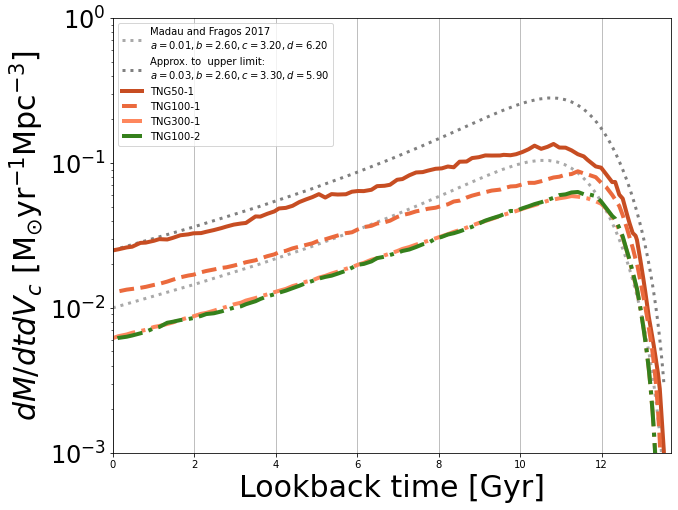

In [41]:
plot_SFR(sf_a = sf_a_best, sf_b = sf_b_best, sf_c = sf_c_best,  sf_d = sf_d_best,show_legend = True,
             redshift_list  = np.linspace(0,15, num=100), x_redshift = False, tmin=0.0, tmax = 13.7)

max value 0.12965691752570246 solMass / (Mpc3 yr)  at x_max =  2.121212121212121
max value 0.08798752047562437 solMass / (Mpc3 yr)  at x_max =  2.7272727272727275
max value 0.06100654620675864 solMass / (Mpc3 yr)  at x_max =  2.7272727272727275
max value 0.06388935341228208 solMass / (Mpc3 yr)  at x_max =  2.7272727272727275
saving here /Users/sashalvna/Research/Fit_SFRD_TNG/figures/SFR_redshift.pdf


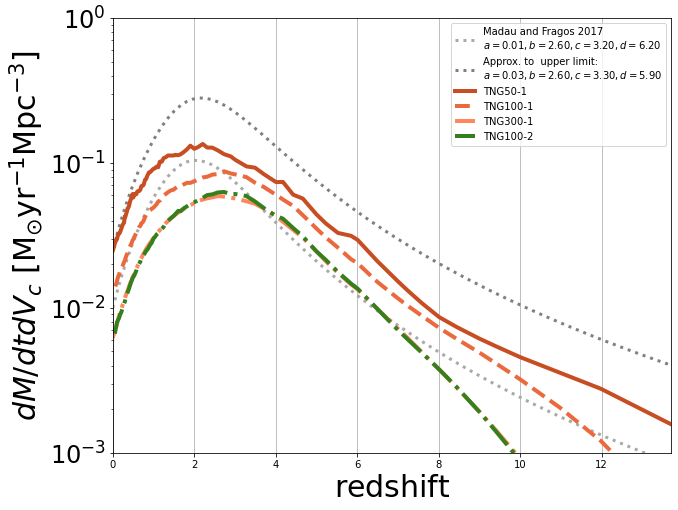

In [42]:
plot_SFR(sf_a = sf_a_best, sf_b = sf_b_best, sf_c = sf_c_best,  sf_d = sf_d_best,show_legend = True,
             redshift_list  = np.linspace(0,15, num=100), x_redshift = True, tmin=0.0, tmax = 13.7)

## Stable BH primary mass distribution for variations of SFRD(Z, z) 

In [ ]:
import matplotlib
matplotlib.use('Agg')

import seaborn as sns
from scipy import stats

import json
import argparse
import gc

# Custom scripts
import MassDistHelperFunctions as mfunc
import Plot_Mass_distributions as pltmass

In [ ]:
# plot setttings
import matplotlib.pyplot as plt
plt.rc('font', family='serif')
from matplotlib import rc

matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('text', usetex=False)
fsize, SMALL_SIZE, MEDIUM_SIZE, BIGGER_SIZE = 30,25,25,30
for obj in ['axes','xtick','ytick']:
    plt.rc(obj, labelsize=MEDIUM_SIZE)          # controls default text sizes
for obj in ['figure','axes']:
    plt.rc(obj, titlesize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize

In [ ]:
#check rate file names
path = data_dir+'/'+rate_file_name
file = h5.File(path, 'r')
list(file.keys())

In [ ]:
#plotting
fig = plt.figure( figsize = (24, 28))
#figure 3: stable MT, no unstable so no CE
only_stable = True 
only_CE     = False 
channel_string = 'stable'

# width of SFRD at z=0 - sigma0 varied
subplot1 = fig.add_subplot(321) #first subplot in layout that has 3 rows and 2 columns
ax1 = pltmass.plot_mass_distribution(sim_dir = data_dir, rate_file='/'+str(rate_file_name), simulation_data = '/'+str(COMPASfilename),
                           x_key = 'M_moreMassive',  rate_keys  = ['Rates_mu0%s_muz%s_alpha%s_sigma0%s_sigmaz%s_a%s_b%s_c%s_d%s_zBinned'%(np.round(mu0_best, 3), np.round(muz_best, 3), np.round(alpha0_best, 3), x, np.round(omegaz_best, 3), np.round(sf_a_best,3), np.round(sf_b_best, 3), np.round(sf_c_best, 3), np.round(sf_d_best,3)) for x in [0.7, np.round(omega0_best, 3), 2.0]], channel_string = channel_string,
                           show_hist = False, show_KDE = True,  plot_LIGO = True, Color =  'navy',
                           only_CE = only_CE, only_stable = only_stable, 
                           bootstrap = False, bootstraps = 50, save_name = 'SFRD_width_variations.pdf', titletext = "Width of metallicity dist."+"\n"+r"$\omega_0$, (scale $z=0$)",
                           labels = [r'$\mathrm{Narrow: \ }  (\omega_0 = 0.70) \  \mathcal{R}_{0.2} = \ $',
                                     r'$\mathrm{Fiducial: \ } (\omega_0 = 1.12) \ \mathcal{R}_{0.2}= \ $', 
                                     r'$\mathrm{Wide: \ } (\omega_0 = 2.00) \  \mathcal{R}_{0.2} = \ $'],
                           multipanel = True, subplot = subplot1)

# Redshift evolution of the width - sigma z varied
subplot2 = fig.add_subplot(322)
ax2 = pltmass.plot_mass_distribution(sim_dir = data_dir,rate_file='/'+str(rate_file_name) , simulation_data = '/'+str(COMPASfilename),
                           x_key = 'M_moreMassive',  rate_keys = ['Rates_mu0%s_muz%s_alpha%s_sigma0%s_sigmaz%s_a%s_b%s_c%s_d%s_zBinned'%(np.round(mu0_best, 3), np.round(muz_best, 3), np.round(alpha0_best, 3), np.round(omega0_best, 3), x, np.round(sf_a_best,3), np.round(sf_b_best, 3), np.round(sf_c_best, 3), np.round(sf_d_best,3)) for x in [0.0, np.round(omegaz_best, 3), 0.1]],channel_string = channel_string,
                           show_hist = False, show_KDE = True,  plot_LIGO = True, Color = '#00a6a0', 
                           only_CE = only_CE, only_stable = only_stable,
                           bootstrap = False, bootstraps = 50, save_name = 'SFRD_zevol_width_variations.pdf',  titletext = "Redshift evol. width of metallicity dist." +"\n"+ r"$\omega_z$, (scale z evol.)",
                           labels = [r'$\mathrm{Flat \ width: \ } (\omega_z = 0.00) \ \mathcal{R}_{0.2} = \ $',
                                     r'$\mathrm{Fiducial: \ } (\omega_z = 0.05) \ \mathcal{R}_{0.2}= \ $', 
                                     r'$\mathrm{Steep \ width: \ } (\omega_z = 0.10) \ \mathcal{R}_{0.2} = \ $'],
                            multipanel = True, subplot = subplot2)

# Mean metallicity at z=0 - mu0 varied
subplot3 = fig.add_subplot(323)
ax3 = pltmass.plot_mass_distribution(sim_dir = data_dir,rate_file='/'+str(rate_file_name) , simulation_data = '/'+str(COMPASfilename),
                           x_key = 'M_moreMassive',  rate_keys = ['Rates_mu0%s_muz%s_alpha%s_sigma0%s_sigmaz%s_a%s_b%s_c%s_d%s_zBinned'%(x, np.round(muz_best, 3), np.round(alpha0_best, 3), np.round(omega0_best, 3), np.round(omegaz_best, 3), np.round(sf_a_best,3), np.round(sf_b_best, 3), np.round(sf_c_best, 3), np.round(sf_d_best,3)) for x in [0.007, np.round(mu0_best, 3), 0.035]],channel_string = channel_string,
                           show_hist = False, show_KDE = True,  plot_LIGO = True, Color = '#e1131d', 
                           only_CE = only_CE, only_stable = only_stable,
                           bootstrap = False, bootstraps = 50, save_name = 'SFRD_meanZ_variations.pdf',  titletext = 'Mean metallicity'+"\n"+r"$\mu_0$",
                           labels = [r'$\mathrm{low \ <Z_0> : \ } (\mu_0 = 0.007) \ \mathcal{R}_{0.2} = \ $',
                                     r'$\mathrm{Fiducial : \ }  (\mu_0 = 0.025) \ \mathcal{R}_{0.2} = \ $',
                                     r'$\mathrm{high \ <Z_0> : \ } (\mu_0 = 0.035) \ \mathcal{R}_{0.2} = \ $'],
                            multipanel = True, subplot = subplot3)

# Redshift evolution of mean metallicity - mu z varied
subplot4 = fig.add_subplot(324)
ax4 = pltmass.plot_mass_distribution(sim_dir = data_dir,rate_file='/'+str(rate_file_name) , simulation_data = '/'+str(COMPASfilename),
                           x_key = 'M_moreMassive',  rate_keys = ['Rates_mu0%s_muz%s_alpha%s_sigma0%s_sigmaz%s_a%s_b%s_c%s_d%s_zBinned'%(np.round(mu0_best, 3), x, np.round(alpha0_best, 3), np.round(omega0_best, 3), np.round(omegaz_best, 3), np.round(sf_a_best,3), np.round(sf_b_best, 3), np.round(sf_c_best, 3), np.round(sf_d_best,3)) for x in [0.0, np.round(muz_best, 3), -0.5]],channel_string = channel_string,
                           show_hist = False, show_KDE = True,  plot_LIGO = True, Color = '#ff717b', 
                           only_CE = only_CE, only_stable = only_stable,
                           bootstrap = False, bootstraps = 50, save_name = 'SFRD_zevol_mean_variations.pdf', titletext = "Redshift evol. of mean metallicity" +"\n"+ r"$\mu_z$", 
                           labels = [r'$\mathrm{Flat: \ }  (\mu_z = 0.0) \ \mathcal{R}_{0.2} = \ $',
                                     r'$\mathrm{Fiducial: \ } (\mu_z = -0.05) \ \mathcal{R}_{0.2}= \ $', 
                                     r'$\mathrm{Steep: \ } (\mu_z = -0.5) \ \mathcal{R}_{0.2} = \ $'],
                            multipanel = True, subplot = subplot4)

# Skewness - alpha varied
subplot5 = fig.add_subplot(325)
ax5 = pltmass.plot_mass_distribution(sim_dir = data_dir,rate_file='/'+str(rate_file_name) , simulation_data = '/'+str(COMPASfilename),
                           x_key = 'M_moreMassive',  rate_keys = ['Rates_mu0%s_muz%s_alpha%s_sigma0%s_sigmaz%s_a%s_b%s_c%s_d%s_zBinned'%(np.round(mu0_best, 3), np.round(muz_best, 3), x, np.round(omega0_best, 3), np.round(omegaz_best, 3), np.round(sf_a_best,3), np.round(sf_b_best, 3), np.round(sf_c_best, 3), np.round(sf_d_best,3)) for x in [0.0, np.round(alpha0_best, 3), -6.0]],channel_string = channel_string,
                           show_hist = False, show_KDE = True, plot_LIGO = True, Color = '#acbf00', 
                           only_CE = only_CE, only_stable = only_stable,
                           bootstrap = False, bootstraps = 50, save_name = 'SFRD_skewness_variations.pdf', titletext = "Skewness of metallicity dist." +"\n"+ r"$\alpha$, (shape)", 
                           labels = [r'$\mathrm{Symmetric: \ } (\alpha = 0.0)   \ \mathcal{R}_{0.2} = \ $',
                                     r'$\mathrm{Fiducial: \  } (\alpha = -1.78)  \ \mathcal{R}_{0.2}= \ $', 
                                     r'$\mathrm{Skewed: \    } (\alpha = -6)  \ \mathcal{R}_{0.2} = \ $'],
                            multipanel = True, subplot = subplot5)

# Star formation norm - SFRD(z) varied
subplot6 = fig.add_subplot(326)
ax6 = pltmass.plot_mass_distribution(sim_dir = data_dir, rate_file='/'+str(rate_file_name), simulation_data = '/'+str(COMPASfilename),
                           x_key = 'M_moreMassive',  
                           rate_keys = ['Rates_mu0%s_muz%s_alpha%s_sigma0%s_sigmaz%s_a%s_b%s_c%s_d%s_zBinned'%(np.round(mu0_best, 3), np.round(muz_best, 3), np.round(alpha0_best, 3), np.round(omega0_best, 3), np.round(omegaz_best, 3), 0.01, 2.6, 3.2, 6.2),
                                       'Rates_mu0%s_muz%s_alpha%s_sigma0%s_sigmaz%s_a%s_b%s_c%s_d%s_zBinned'%(np.round(mu0_best, 3), np.round(muz_best, 3), np.round(alpha0_best, 3), np.round(omega0_best, 3), np.round(omegaz_best, 3), np.round(sf_a_best,3), np.round(sf_b_best, 3), np.round(sf_c_best, 3), np.round(sf_d_best,3)), 
                                       'Rates_mu0%s_muz%s_alpha%s_sigma0%s_sigmaz%s_a%s_b%s_c%s_d%s_zBinned'%(np.round(mu0_best, 3), np.round(muz_best, 3), np.round(alpha0_best, 3), np.round(omega0_best, 3), np.round(omegaz_best, 3), 0.03, 2.6, 3.3, 5.9)],
                                 channel_string = channel_string,
                           show_hist = False, show_KDE = True,  plot_LIGO = True, Color = '#ecb05b', 
                           only_CE = only_CE, only_stable = only_stable,
                           bootstrap = False, bootstraps = 50, save_name = 'SFRD_skewness_variations.pdf', titletext = "Overall SFR history"+"\n"+ r'$ \mathrm{SFRD(}z\rm{)} \ [a,b,c,d]$', 
                           labels = [r'$\mathrm{Madau \ and \ Fragos \ 2017: }  \ \mathcal{R}_{0.2}= \ $', 
                                     r'$\mathrm{Fiducial: \ } \ \mathcal{R}_{0.2}= \ $', 
                                     r'$\mathrm{Approx. \ to \ upper \ limit:}  \ \mathcal{R}_{0.2} = \ $'],
                            multipanel = True, subplot = subplot6)

fig.savefig('Massdistribitions_stable_TNG300.png')

In [ ]:
#plotting
fig = plt.figure( figsize = (24, 28))
#figure 4: unstable MT, so CE
only_stable = False 
only_CE     = True 
channel_string = 'CE'

# width of SFRD at z=0 - sigma0 varied
subplot1 = fig.add_subplot(321) #first subplot in layout that has 3 rows and 2 columns
ax1 = pltmass.plot_mass_distribution(sim_dir = data_dir, rate_file='/'+str(rate_file_name), simulation_data = '/'+str(COMPASfilename),
                           x_key = 'M_moreMassive',  rate_keys  = ['Rates_mu0%s_muz%s_alpha%s_sigma0%s_sigmaz%s_a%s_b%s_c%s_d%s_zBinned'%(np.round(mu0_best, 3), np.round(muz_best, 3), np.round(alpha0_best, 3), x, np.round(omegaz_best, 3), np.round(sf_a_best,3), np.round(sf_b_best, 3), np.round(sf_c_best, 3), np.round(sf_d_best,3)) for x in [0.7, np.round(omega0_best, 3), 2.0]], channel_string = channel_string,
                           show_hist = False, show_KDE = True,  plot_LIGO = True, Color =  'navy',
                           only_CE = only_CE, only_stable = only_stable, 
                           bootstrap = False, bootstraps = 50, save_name = 'SFRD_width_variations.pdf', titletext = "Width of metallicity dist."+"\n"+r"$\omega_0$, (scale $z=0$)",
                           labels = [r'$\mathrm{Narrow: \ }  (\omega_0 = 0.70) \  \mathcal{R}_{0.2} = \ $',
                                     r'$\mathrm{Fiducial: \ } (\omega_0 = 1.12) \ \mathcal{R}_{0.2}= \ $', 
                                     r'$\mathrm{Wide: \ } (\omega_0 = 2.00) \  \mathcal{R}_{0.2} = \ $'],
                           multipanel = True, subplot = subplot1)

# Redshift evolution of the width - sigma z varied
subplot2 = fig.add_subplot(322)
ax2 = pltmass.plot_mass_distribution(sim_dir = data_dir,rate_file='/'+str(rate_file_name) , simulation_data = '/'+str(COMPASfilename),
                           x_key = 'M_moreMassive',  rate_keys = ['Rates_mu0%s_muz%s_alpha%s_sigma0%s_sigmaz%s_a%s_b%s_c%s_d%s_zBinned'%(np.round(mu0_best, 3), np.round(muz_best, 3), np.round(alpha0_best, 3), np.round(omega0_best, 3), x, np.round(sf_a_best,3), np.round(sf_b_best, 3), np.round(sf_c_best, 3), np.round(sf_d_best,3)) for x in [0.0, np.round(omegaz_best, 3), 0.1]],channel_string = channel_string,
                           show_hist = False, show_KDE = True,  plot_LIGO = True, Color = '#00a6a0', 
                           only_CE = only_CE, only_stable = only_stable,
                           bootstrap = False, bootstraps = 50, save_name = 'SFRD_zevol_width_variations.pdf',  titletext = "Redshift evol. width of metallicity dist." +"\n"+ r"$\omega_z$, (scale z evol.)",
                           labels = [r'$\mathrm{Flat \ width: \ } (\omega_z = 0.00) \ \mathcal{R}_{0.2} = \ $',
                                     r'$\mathrm{Fiducial: \ } (\omega_z = 0.05) \ \mathcal{R}_{0.2}= \ $', 
                                     r'$\mathrm{Steep \ width: \ } (\omega_z = 0.10) \ \mathcal{R}_{0.2} = \ $'],
                            multipanel = True, subplot = subplot2)

# Mean metallicity at z=0 - mu0 varied
subplot3 = fig.add_subplot(323)
ax3 = pltmass.plot_mass_distribution(sim_dir = data_dir,rate_file='/'+str(rate_file_name) , simulation_data = '/'+str(COMPASfilename),
                           x_key = 'M_moreMassive',  rate_keys = ['Rates_mu0%s_muz%s_alpha%s_sigma0%s_sigmaz%s_a%s_b%s_c%s_d%s_zBinned'%(x, np.round(muz_best, 3), np.round(alpha0_best, 3), np.round(omega0_best, 3), np.round(omegaz_best, 3), np.round(sf_a_best,3), np.round(sf_b_best, 3), np.round(sf_c_best, 3), np.round(sf_d_best,3)) for x in [0.007, np.round(mu0_best, 3), 0.035]],channel_string = channel_string,
                           show_hist = False, show_KDE = True,  plot_LIGO = True, Color = '#e1131d', 
                           only_CE = only_CE, only_stable = only_stable,
                           bootstrap = False, bootstraps = 50, save_name = 'SFRD_meanZ_variations.pdf',  titletext = 'Mean metallicity'+"\n"+r"$\mu_0$",
                           labels = [r'$\mathrm{low \ <Z_0> : \ } (\mu_0 = 0.007) \ \mathcal{R}_{0.2} = \ $',
                                     r'$\mathrm{Fiducial : \ }  (\mu_0 = 0.025) \ \mathcal{R}_{0.2} = \ $',
                                     r'$\mathrm{high \ <Z_0> : \ } (\mu_0 = 0.035) \ \mathcal{R}_{0.2} = \ $'],
                            multipanel = True, subplot = subplot3)

# Redshift evolution of mean metallicity - mu z varied
subplot4 = fig.add_subplot(324)
ax4 = pltmass.plot_mass_distribution(sim_dir = data_dir,rate_file='/'+str(rate_file_name) , simulation_data = '/'+str(COMPASfilename),
                           x_key = 'M_moreMassive',  rate_keys = ['Rates_mu0%s_muz%s_alpha%s_sigma0%s_sigmaz%s_a%s_b%s_c%s_d%s_zBinned'%(np.round(mu0_best, 3), x, np.round(alpha0_best, 3), np.round(omega0_best, 3), np.round(omegaz_best, 3), np.round(sf_a_best,3), np.round(sf_b_best, 3), np.round(sf_c_best, 3), np.round(sf_d_best,3)) for x in [0.0, np.round(muz_best, 3), -0.5]],channel_string = channel_string,
                           show_hist = False, show_KDE = True,  plot_LIGO = True, Color = '#ff717b', 
                           only_CE = only_CE, only_stable = only_stable,
                           bootstrap = False, bootstraps = 50, save_name = 'SFRD_zevol_mean_variations.pdf', titletext = "Redshift evol. of mean metallicity" +"\n"+ r"$\mu_z$", 
                           labels = [r'$\mathrm{Flat: \ }  (\mu_z = 0.0) \ \mathcal{R}_{0.2} = \ $',
                                     r'$\mathrm{Fiducial: \ } (\mu_z = -0.05) \ \mathcal{R}_{0.2}= \ $', 
                                     r'$\mathrm{Steep: \ } (\mu_z = -0.5) \ \mathcal{R}_{0.2} = \ $'],
                            multipanel = True, subplot = subplot4)

# Skewness - alpha varied
subplot5 = fig.add_subplot(325)
ax5 = pltmass.plot_mass_distribution(sim_dir = data_dir,rate_file='/'+str(rate_file_name) , simulation_data = '/'+str(COMPASfilename),
                           x_key = 'M_moreMassive',  rate_keys = ['Rates_mu0%s_muz%s_alpha%s_sigma0%s_sigmaz%s_a%s_b%s_c%s_d%s_zBinned'%(np.round(mu0_best, 3), np.round(muz_best, 3), x, np.round(omega0_best, 3), np.round(omegaz_best, 3), np.round(sf_a_best,3), np.round(sf_b_best, 3), np.round(sf_c_best, 3), np.round(sf_d_best,3)) for x in [0.0, np.round(alpha0_best, 3), -6.0]],channel_string = channel_string,
                           show_hist = False, show_KDE = True, plot_LIGO = True, Color = '#acbf00', 
                           only_CE = only_CE, only_stable = only_stable,
                           bootstrap = False, bootstraps = 50, save_name = 'SFRD_skewness_variations.pdf', titletext = "Skewness of metallicity dist." +"\n"+ r"$\alpha$, (shape)", 
                           labels = [r'$\mathrm{Symmetric: \ } (\alpha = 0.0)   \ \mathcal{R}_{0.2} = \ $',
                                     r'$\mathrm{Fiducial: \  } (\alpha = -1.78)  \ \mathcal{R}_{0.2}= \ $', 
                                     r'$\mathrm{Skewed: \    } (\alpha = -6)  \ \mathcal{R}_{0.2} = \ $'],
                            multipanel = True, subplot = subplot5)

# Star formation norm - SFRD(z) varied
subplot6 = fig.add_subplot(326)
ax6 = pltmass.plot_mass_distribution(sim_dir = data_dir, rate_file='/'+str(rate_file_name), simulation_data = '/'+str(COMPASfilename),
                           x_key = 'M_moreMassive',  
                           rate_keys = ['Rates_mu0%s_muz%s_alpha%s_sigma0%s_sigmaz%s_a%s_b%s_c%s_d%s_zBinned'%(np.round(mu0_best, 3), np.round(muz_best, 3), np.round(alpha0_best, 3), np.round(omega0_best, 3), np.round(omegaz_best, 3), 0.01, 2.6, 3.2, 6.2),
                                       'Rates_mu0%s_muz%s_alpha%s_sigma0%s_sigmaz%s_a%s_b%s_c%s_d%s_zBinned'%(np.round(mu0_best, 3), np.round(muz_best, 3), np.round(alpha0_best, 3), np.round(omega0_best, 3), np.round(omegaz_best, 3), np.round(sf_a_best,3), np.round(sf_b_best, 3), np.round(sf_c_best, 3), np.round(sf_d_best,3)), 
                                       'Rates_mu0%s_muz%s_alpha%s_sigma0%s_sigmaz%s_a%s_b%s_c%s_d%s_zBinned'%(np.round(mu0_best, 3), np.round(muz_best, 3), np.round(alpha0_best, 3), np.round(omega0_best, 3), np.round(omegaz_best, 3), 0.03, 2.6, 3.3, 5.9)],
                                 channel_string = channel_string,
                           show_hist = False, show_KDE = True,  plot_LIGO = True, Color = '#ecb05b', 
                           only_CE = only_CE, only_stable = only_stable,
                           bootstrap = False, bootstraps = 50, save_name = 'SFRD_skewness_variations.pdf', titletext = "Overall SFR history"+"\n"+ r'$ \mathrm{SFRD(}z\rm{)} \ [a,b,c,d]$', 
                           labels = [r'$\mathrm{Madau \ and \ Fragos \ 2017: }  \ \mathcal{R}_{0.2}= \ $', 
                                     r'$\mathrm{Fiducial: \ } \ \mathcal{R}_{0.2}= \ $', 
                                     r'$\mathrm{Approx. \ to \ upper \ limit:}  \ \mathcal{R}_{0.2} = \ $'],
                            multipanel = True, subplot = subplot6)

fig.savefig('Massdistribitions_CE_TNG300.png')